# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from utils import load_complete_time_series, plot_multiple_time_series_attributes, split_data_into_sequences
from visual_evaluation import visualize
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
data_real = load_complete_time_series(REAL_DATA_FOLDER/'AAPL_22_23_real.csv')
data_syn = load_complete_time_series(SYNTHETIC_DATA_FOLDER/'AAPL_22_23_syn.csv')

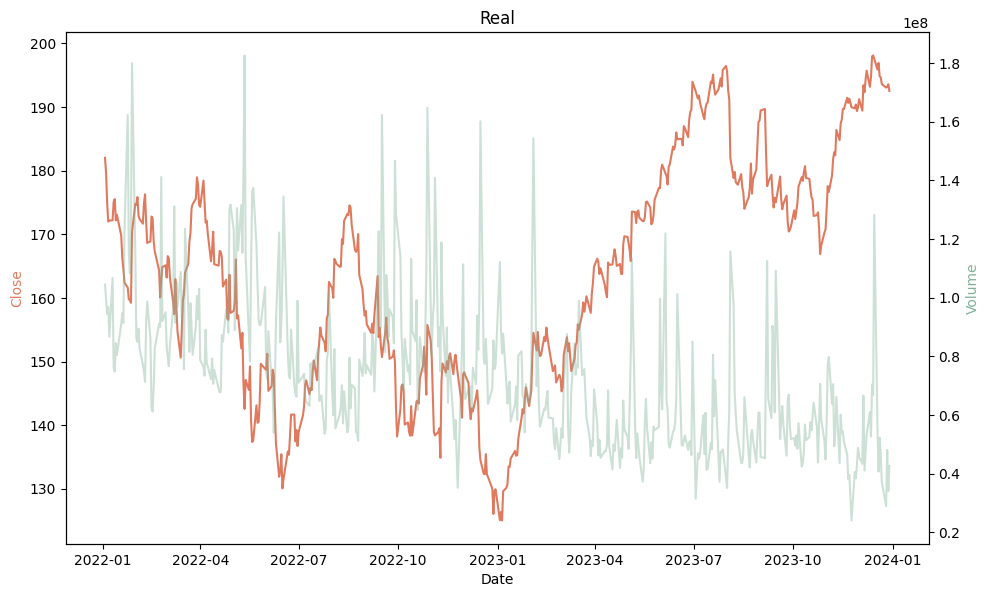

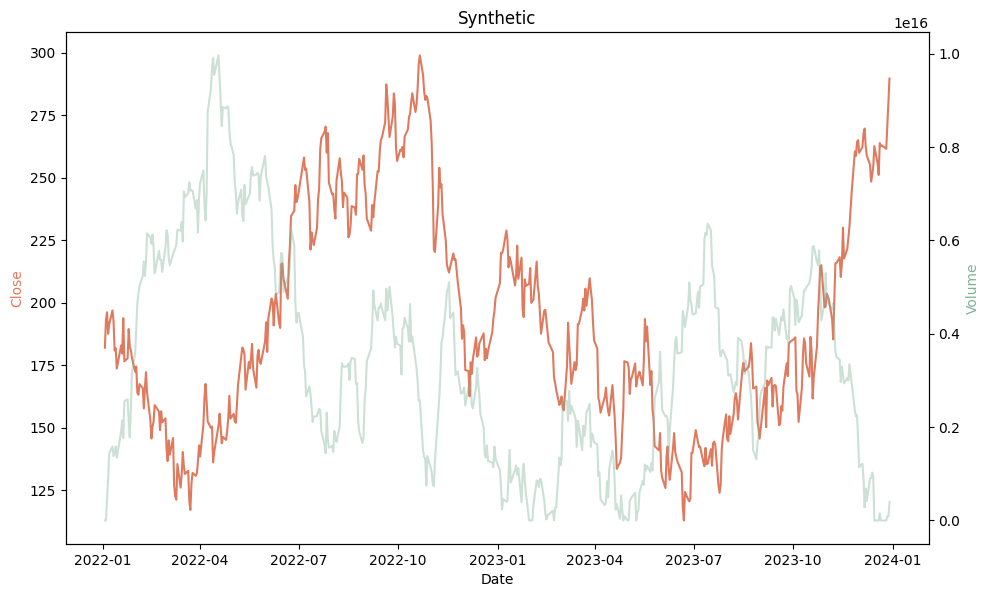

In [5]:
plot_multiple_time_series_attributes(data_real, title="Real")
plot_multiple_time_series_attributes(data_syn, title="Synthetic")

## 2 Train and Test Baseline Model

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 15,
    "lr": 0.001,
    "batch_size": 32,
    "hidden_size": 12,
    "num_layers": 1,
    "num_epochs": 1000,
}

features = ['Close', 'Open', 'High', 'Low', 'Adj Close', 'Volume'] # remember to put the target attribute at the first position and exclude 'Date'

In [7]:
# convert data to numpy
data_real_numpy = data_real[features].to_numpy()
data_syn_numpy = data_syn[features].to_numpy()

In [8]:
# split into sequences
data_real_split = split_data_into_sequences(data_real_numpy, seq_len=hyperparameters["seq_len"])
data_syn_split = split_data_into_sequences(data_syn_numpy, seq_len=hyperparameters["seq_len"])

Shape of the data after splitting into sequences: (486, 15, 6)
Shape of the data after splitting into sequences: (486, 15, 6)


In [9]:
results = predictive_evaluation(data_real_split, data_syn_split, hyperparameters, features)

Epoch: 1


/home/allwardt/time_series_data_augmentation/ba_venv_3_8_10/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/allwardt/time_series_data_augmentation/ba_venv_3_8_10/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation Loss: 0.06539189870818518
**************************************************
Epoch: 2
Validation Loss: 0.053601000807248056
**************************************************
Epoch: 3
Validation Loss: 0.05494510568678379
INFO: Validation loss did not improve in epoch 3
**************************************************
Epoch: 4
Validation Loss: 0.058164335088804364
INFO: Validation loss did not improve in epoch 4
**************************************************
Epoch: 5
Validation Loss: 0.05746469396399334
INFO: Validation loss did not improve in epoch 5
**************************************************
Epoch: 6
Validation Loss: 0.054761999228503555
INFO: Validation loss did not improve in epoch 6
**************************************************
Epoch: 7
Validation Loss: 0.052413842699024826
**************************************************
Epoch: 8
Validation Loss: 0.05073689919663593
**************************************************
Epoch: 9
Validation Loss: 0.04916

In [18]:
print(f'Train on Real, Test on Synthetic (TRTS) MAE: \n{results["TRTS_validation_loss"]}\n')
print(f'Train on Synthetic, Test on Real (TSTR) MAE: \n{results["TSTR_validation_loss"]}')

Train on Real, Test on Synthetic (TRTS) MAE: 
0.040336976817343384

Train on Synthetic, Test on Real (TSTR) MAE: 
0.013196638465160504


## 3 Visualize Synthetic vs Real Data

Preprocessing data. Shape: (486, 15, 6)
Data has been preprocessed. Shape: (486, 90)


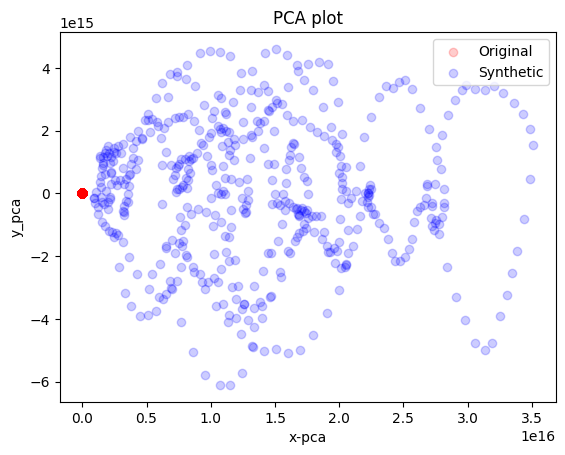

Preprocessing data. Shape: (486, 15, 6)
Data has been preprocessed. Shape: (486, 90)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 972 samples in 0.001s...
[t-SNE] Computed neighbors for 972 samples in 0.322s...
[t-SNE] Computed conditional probabilities for sample 972 / 972
[t-SNE] Mean sigma: 42030765.785373
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.043488
[t-SNE] KL divergence after 300 iterations: 1.486944


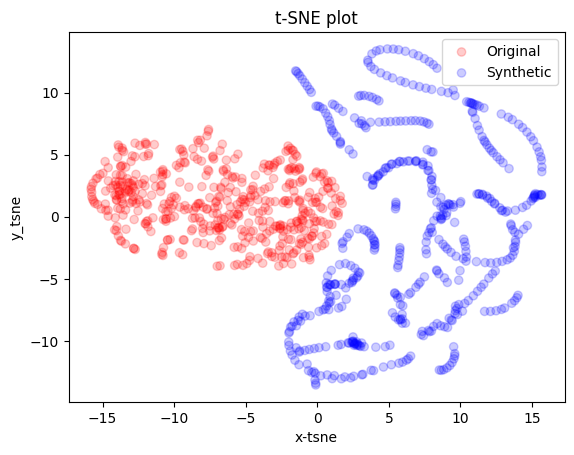

In [ ]:
visualize(data_real_split, data_syn_split, metric='pca')
visualize(data_real_split, data_syn_split, metric='tsne')

### Beispielaussage:
PCA-Analyse von Realen und Synthetischen Daten
Um die Ähnlichkeit zwischen den realen und synthetischen Daten zu bewerten, wurde eine Principal Component Analysis (PCA) durchgeführt. Die PCA reduziert die Dimensionalität der Daten und projiziert sie auf eine zweidimensionale Ebene, wobei die Hauptkomponenten beibehalten werden, die den größten Teil der Varianz erklären.

Abbildung X zeigt den PCA-Plot der realen (rote Punkte) und synthetischen Daten (blaue Punkte). Die folgenden Beobachtungen können gemacht werden:

Verteilung und Clusterbildung:

Die roten Punkte, die die realen Daten repräsentieren, sind in einem spezifischen Bereich konzentriert.
Die blauen Punkte, die die synthetischen Daten darstellen, zeigen eine größere Verteilung und decken einen breiteren Bereich ab.
Ähnlichkeit und Unterschiede:

Die Tatsache, dass die synthetischen Daten eine größere Variabilität aufweisen, könnte darauf hinweisen, dass sie eine breitere Vielfalt an Mustern generieren.
Die Cluster der realen und synthetischen Daten überlappen sich teilweise, was darauf hindeutet, dass die synthetischen Daten einige der Eigenschaften der realen Daten gut nachahmen. Allerdings gibt es auch Bereiche, in denen die synthetischen Daten stark von den realen Daten abweichen, was auf Unterschiede in den zugrunde liegenden Verteilungen hinweist.
Schlussfolgerung:

Die PCA-Analyse zeigt, dass die synthetischen Daten in gewissem Maße die Struktur der realen Daten einfangen, jedoch eine größere Variabilität aufweisen.
Weitere Untersuchungen und Anpassungen am Generierungsprozess der synthetischen Daten könnten notwendig sein, um deren Genauigkeit und Übereinstimmung mit den realen Daten zu verbessern.